## 客户转化率EDA及预测分析

项目背景：
1. 目前我们有某网站的用户行为数据，以及最后转化效果，想提高用户的转化率

2. 目的是建立一个可预测转化率的模型，并在此模型的基础上提出提高收益的想法


参考链接：
1. 《a collection of data science take home challenge》 
2. H2o官方文档
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html
3. https://github.com/h2oai/h2o-3/blob/master/h2o-py/demos/pdp_multiclass.ipynb
4. https://github.com/JifuZhao/DS-Take-Home/blob/master/01.%20Conversion%20Rate.ipynb
5. https://www.pavel.cool/machine%20learning/h2o-3/h2o-3-tree-api/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
rate=pd.read_csv("D:/takehome/conversion_data.csv")

In [2]:
rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [3]:
rate.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
rate.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
rate['source'].value_counts()

Seo       155040
Ads        88740
Direct     72420
Name: source, dtype: int64

In [6]:
rate['country'].value_counts()

US         178092
China       76602
UK          48450
Germany     13056
Name: country, dtype: int64

描述性分析这里可以看出，
该网站可能是美国网站，用户群体年龄比较年轻30岁左右，转化率基本在3%
数据错误地方，可以看到年龄有123岁，这显然不对，我们可以看看年龄分布做进一步推断。
可以看出100岁以上的只有2个，这里做直接删除处理。

In [7]:
rate['age'].unique()

array([ 25,  23,  28,  39,  30,  31,  27,  29,  38,  43,  24,  36,  37,
        33,  20,  35,  17,  50,  22,  18,  34,  19,  42,  32,  21,  48,
        40,  41,  26,  45,  44,  49,  46,  56,  52,  54,  51,  47,  53,
        60,  57,  55,  59,  61,  58,  62,  65,  63,  66,  67,  64,  68,
        69, 123,  70,  73,  77,  72,  79, 111], dtype=int64)

In [8]:
rate.loc[rate.age>=100,:]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [9]:
rate=rate.loc[rate.age<100,:]

In [10]:
rate.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


In [11]:
aggResult=rate.groupby(['country']).mean()['converted'].reset_index()
# 使用百分比的形式进行数据的展示

aggResult
#aggResult.plot(kind="bar")

,country,converted
0,China,0.001332
1,Germany,0.062428
2,UK,0.052612
3,US,0.037801


中国的转化率要其他国家低！在网上花费更多时间会有更大的转化率！

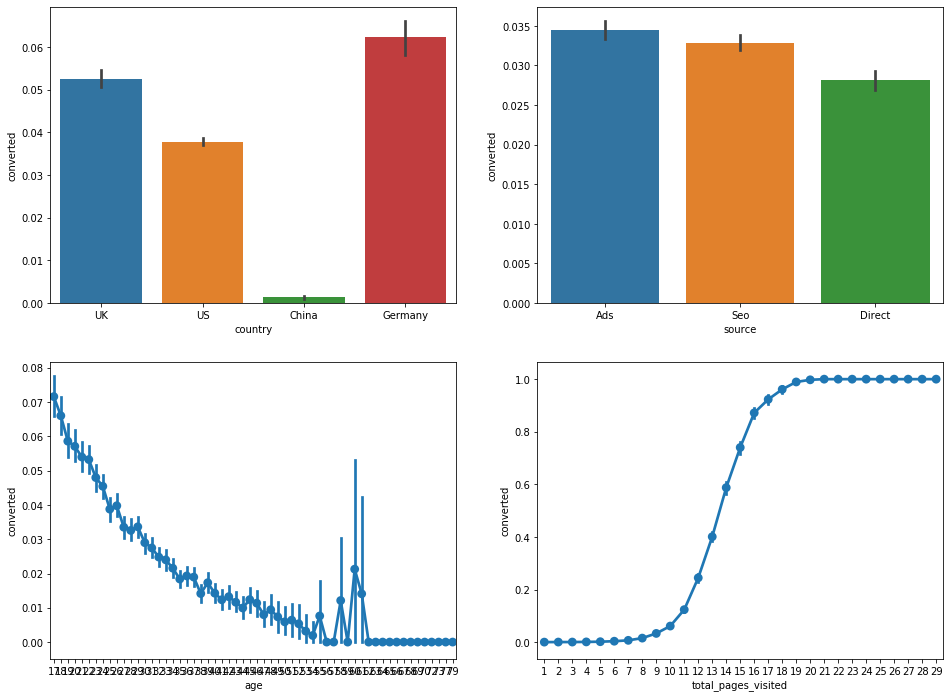

In [12]:
fig, saxis = plt.subplots(2,2 ,figsize=(16,12))

sns.barplot(x = 'country', y = 'converted', data=rate, ax = saxis[0,0])
sns.barplot(x = 'source', y = 'converted',  data=rate, ax = saxis[0,1])

sns.pointplot(x = 'age', y = 'converted',  data=rate, ax = saxis[1,0])
sns.pointplot(x = 'total_pages_visited', y = 'converted',  data=rate, ax = saxis[1,1])

## 现在让我们建立一个模型来预测转化率。这是二分类问题，我们关心的是趋势情况，以便为产品和营销团队提供一些想法。这里选用随机森林模型

我选择了一个随机的森林原因：通常只需很少的时间对其进行优化（其默认参数通常接近最佳参数），并且有可以很好处理异常值、无关变量、连续变量和离散变量的优点。

我将使用随机森林来预测转换，然后将使用偏相关和变量重要性来了解有关它如何从变量中获取信息的理解。

另外，我将构建一棵简单的树来查找最明显的用户细分，并查看它们是否与 RF 部分依赖图一致。

备注：H2O参数介绍：
https://docs.h2o.ai/h2o/latest-stable/h2o-r/docs/reference/h2o.partialPlot.html

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html

AUC介绍：https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

In [13]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [14]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.211-b12, mixed mode)
  Starting server from C:\Users\1\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\1\AppData\Local\Temp\tmpm8z_l9gu
  JVM stdout: C:\Users\1\AppData\Local\Temp\tmpm8z_l9gu\h2o_1_started_from_python.out
  JVM stderr: C:\Users\1\AppData\Local\Temp\tmpm8z_l9gu\h2o_1_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Shanghai
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,8 days
H2O_cluster_name:,H2O_from_python_1_ocs109
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,891 Mb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [15]:
h2o_df = H2OFrame(rate)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.5693110013347,,,4.872918234777034,
maxs,,79.0,,,29.0,
sigma,,8.268957596421474,,,3.3410533442156267,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [16]:
# Split into 67% training and 33% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.30, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [17]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


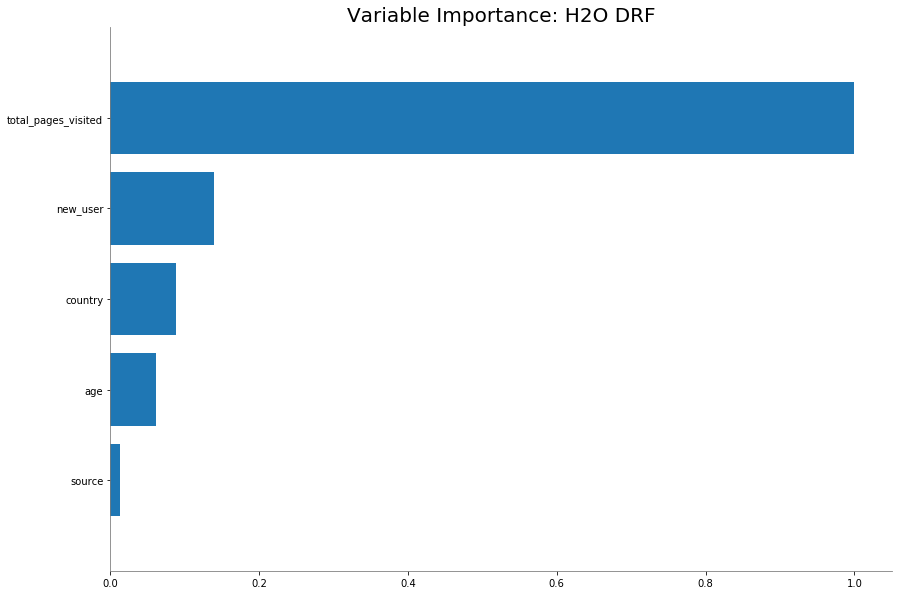

In [18]:
#重要性
model.varimp_plot()

In [19]:
#概览模型
perf = model.model_performance()
perf


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.11782559177527036
RMSE: 0.3432573258872567
LogLoss: 0.37509840784363957
Mean Per-Class Error: 0.040404090529997716
AUC: 0.9929220276257185
AUCPR: 0.9917812139421185
Gini: 0.9858440552514369

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.02955005098955254: 


,,0,1,Error,Rate
0,0,202909.0,11291.0,0.0527,(11291.0/214200.0)
1,1,6018.0,208178.0,0.0281,(6018.0/214196.0)
2,Total,208927.0,219469.0,0.0404,(17309.0/428396.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.029550,0.960087,377.0
1,max f2,0.010155,0.977889,388.0
2,max f0point5,0.086368,0.962072,351.0
3,max accuracy,0.029550,0.959596,377.0
4,max precision,0.999433,1.000000,0.0
5,max recall,0.002687,1.000000,393.0
6,max specificity,0.999433,1.000000,0.0
7,max absolute_mcc,0.029550,0.919470,377.0
8,max min_per_class_accuracy,0.042474,0.958301,371.0
9,max mean_per_class_accuracy,0.029550,0.959596,377.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 31.96 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010000,0.993874,1.999085,1.999085,0.999533,0.996683,0.999533,0.996683,0.019991,0.019991,99.908496,99.908496,0.019982
1,2,0.020000,0.989222,1.998618,1.998852,0.999300,0.991506,0.999416,0.994095,0.019986,0.039977,99.861810,99.885153,0.039954
2,3,0.030000,0.984963,1.999552,1.999085,0.999767,0.987114,0.999533,0.991768,0.019996,0.059973,99.955182,99.908496,0.059945
3,4,0.040000,0.980246,1.999085,1.999085,0.999533,0.982633,0.999533,0.989484,0.019991,0.079964,99.908496,99.908496,0.079927
4,5,0.050000,0.975386,1.998618,1.998992,0.999300,0.977783,0.999486,0.987144,0.019986,0.099951,99.861810,99.899159,0.099899
5,6,0.100001,0.932333,1.995910,1.997451,0.997946,0.958592,0.998716,0.972868,0.099796,0.199747,99.591033,99.745096,0.199490
6,7,0.150001,0.855443,1.993016,1.995973,0.996499,0.893457,0.997977,0.946398,0.099652,0.299399,99.301581,99.597257,0.298792
7,8,0.200002,0.797783,1.992549,1.995117,0.996265,0.825471,0.997549,0.916166,0.099628,0.399027,99.254895,99.511667,0.398047
8,9,0.300000,0.621902,1.986386,1.992207,0.993184,0.717757,0.996094,0.850031,0.198636,0.597663,98.638611,99.220653,0.595319
9,10,0.400001,0.307289,1.947637,1.981064,0.973810,0.480285,0.990523,0.757594,0.194766,0.792428,94.763723,98.106414,0.784847


由于前面概览可以知道AUC高达99%，极容易出现过拟合状态，结合重要性可以推测，点击重要度之所以比较高，可能是因为用户本身就有购买意愿，算是一个因果倒置的因素，这里把total_pages_visited 删除，再进行拟合。

In [20]:
feature = ['country', 'age', 'new_user', 'source']
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [21]:
#概览模型
perf = model.model_performance()
perf


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.41771840396346227
RMSE: 0.6463113831300377
LogLoss: 1.3833186377724385
Mean Per-Class Error: 0.2522427932311322
AUC: 0.8265257310385233
AUCPR: 0.7988824428173403
Gini: 0.6530514620770467

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.01958305568425701: 


,,0,1,Error,Rate
0,0,126622.0,87578.0,0.4089,(87578.0/214200.0)
1,1,26394.0,187802.0,0.1232,(26394.0/214196.0)
2,Total,153016.0,275380.0,0.266,(113972.0/428396.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.019583,0.767203,346.0
1,max f2,0.008156,0.868497,377.0
2,max f0point5,0.050910,0.755336,279.0
3,max accuracy,0.029128,0.747757,323.0
4,max precision,0.285378,0.938080,11.0
5,max recall,0.000846,1.000000,396.0
6,max specificity,0.346541,0.999995,0.0
7,max absolute_mcc,0.028037,0.498396,325.0
8,max min_per_class_accuracy,0.032511,0.745728,313.0
9,max mean_per_class_accuracy,0.029128,0.747757,323.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score:  5.96 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010000,0.240881,1.820278,1.820278,0.910131,0.256665,0.910131,0.256665,0.018203,0.018203,82.027843,82.027843,0.016406
1,2,0.020000,0.225715,1.803005,1.811642,0.901494,0.233042,0.905812,0.244853,0.018030,0.036233,80.300470,81.164157,0.032466
2,3,0.030000,0.200549,1.788065,1.803783,0.894024,0.211043,0.901883,0.233583,0.017881,0.054114,78.806525,80.378279,0.048227
3,4,0.040000,0.193833,1.770792,1.795535,0.885387,0.196933,0.897759,0.224421,0.017708,0.071822,77.079151,79.553497,0.063643
4,5,0.050000,0.181490,1.770792,1.790586,0.885387,0.188727,0.895285,0.217282,0.017708,0.089530,77.079151,79.058628,0.079059
5,6,0.100001,0.139636,1.715235,1.752911,0.857610,0.156334,0.876447,0.186808,0.085763,0.175293,71.523544,75.291086,0.150582
6,7,0.150001,0.127406,1.657252,1.721024,0.828618,0.132080,0.860504,0.168565,0.082863,0.258156,65.725170,72.102447,0.216307
7,8,0.200002,0.114042,1.625225,1.697075,0.812605,0.121761,0.848529,0.156864,0.081262,0.339418,62.522526,69.707467,0.278830
8,9,0.300000,0.088664,1.554112,1.649421,0.777049,0.103172,0.824703,0.138967,0.155409,0.494827,55.411241,64.942133,0.389650
9,10,0.400001,0.054710,1.388482,1.584186,0.694234,0.069756,0.792086,0.121664,0.138849,0.633677,38.848169,58.418603,0.467346


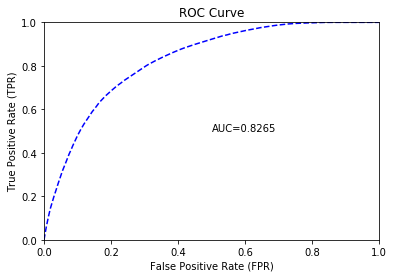

In [22]:
##绘制ROC-AUC
performace = model.model_performance(train=True)
performace.plot()

In [23]:
#进行预测
pred = model.predict(test)
pred

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,p0,p1
1,0.928706,0.0712945
0,0.999615,0.000385072
1,0.875448,0.124552
1,0.864409,0.135591
1,0.958662,0.0413383
1,0.926522,0.0734781
0,0.997015,0.00298539
0,0.999558,0.000441911
0,0.993077,0.0069232
0,0.986764,0.0132363


PartialDependencePlot progress: |█████████████████████████████████████████| 100%


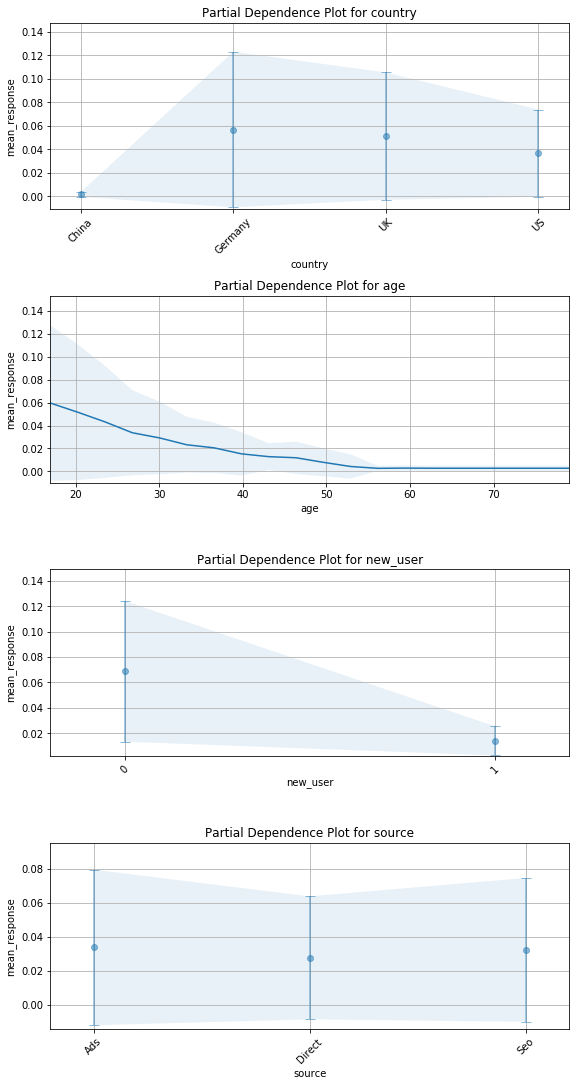

In [24]:
#接着， 我们来看看，以图形方式描述了变量对类别概率（分类）或响应（回归）的边际影响。
data=model.partial_plot(data=train, cols=feature, plot=True, figsize=(8, 15) )

在偏相关图中，我们只关心趋势，而不关心实际的 y 值。因此，这表明：
具有旧帐户的用户比新用户要好得多
中国用户转化率最低，其他所有国家都很相似，德国是最好的
该网站对年轻人来说效果很好，而对年轻人数量较少（> 30 岁）则不利。

In [25]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_b761 closed.


一些结论和建议：
1. 该网站对年轻用户来说运作良好。我们需要告诉营销人员做广告和使用营销渠道，这些渠道应该更可能覆盖年轻人。
2. 德国转换率很好，但是德国人来我们网站人数还是很少，营销应该吸引更多的德国人。
3. 使用老账户的用户转化方面做的更好。可以利用短信等方式提供一些优惠，给他们带来回流。
4. 该网站的中文版本出了点问题。它要么翻译不善，不符合当地文化，有些付款问题，要么只是英语！考虑到中国有多少用户，解决此问题应该是当务之急。巨大的机会。
5. 也许通过 UI 找出为什么网站对那些老年朋友表现如此差？从30岁开始可以明显看到转化率下滑了。
6. 如果我知道有人访问了许多页面，但是没有转换，那么她几乎肯定有很高的购买意愿。我可以给她发送有针对性的报价或发送提醒。总体而言，这些用户可能是最容易转换的用户。

如您所见，结论通常最终是关于：
1. 告诉市场营销以获取更多表现良好的用户群
2. 告诉产品修复性能不好的产品的经验